<a href="https://colab.research.google.com/github/neworderofjamie/riscv_ise/blob/compiler/tutorials/alif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are lots of rough edges here: error checking is lacking in places, the compiler supports an even smaller subset of C than it should and the wrapping of various bits of API is not very Pythonic.

# Installation
The current prototype FeNN toolchain is a little bit tricky to build as it re-uses parts of GeNN (mostly the type system and the GeNNCode scanner, parser and type checker) so, on colab, we can install a prebuilt wheel from my google drive:

In [1]:
if "google.colab" in str(get_ipython()):
    !gdown 1hEx5nI2ITfmrrjfidr5y1SyWnsjFI8Qq
    !pip install pyfenn-0.0.1-cp311-cp311-linux_x86_64.whl

Downloading...
From: https://drive.google.com/uc?id=1hEx5nI2ITfmrrjfidr5y1SyWnsjFI8Qq
To: /content/pyfenn-0.0.1-cp311-cp311-linux_x86_64.whl
100% 6.38M/6.38M [00:00<00:00, 95.6MB/s]
Processing ./pyfenn-0.0.1-cp311-cp311-linux_x86_64.whl
pyfenn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyfenn import (BackendFeNNSim, CopyProcess, EventContainer, Model, NeuronUpdateProcess,
                    NumericValue, Parameter, PlogSeverity, ProcessGroup,
                    Runtime, Shape, UnresolvedType, Variable)

from pyfenn import disassemble, init_logging
from pyfenn.utils import get_array_view, zero_and_push

# Stimulus generation
To test our ALIF neuron, in a semi-realistic regime, we want to generate some bursty poisson noise to simulate a large number of incoming neurons:

In [3]:
background_rate = 0.5
rate = 7846 / 1370
num_timesteps = 1000

# Generate poisson data with two periods of average firing interspersed by background
data = np.zeros(num_timesteps)
data[0:400] = np.random.poisson(rate, 400)
data[400:600] = np.random.poisson(background_rate, 200)
data[600:] = np.random.poisson(rate, 400)

repeated_data = np.repeat(data[:,None], 32, axis=1).astype(np.int16)

Visualise to see what this looks like:

Text(0.5, 0, 'Time [timestep]')

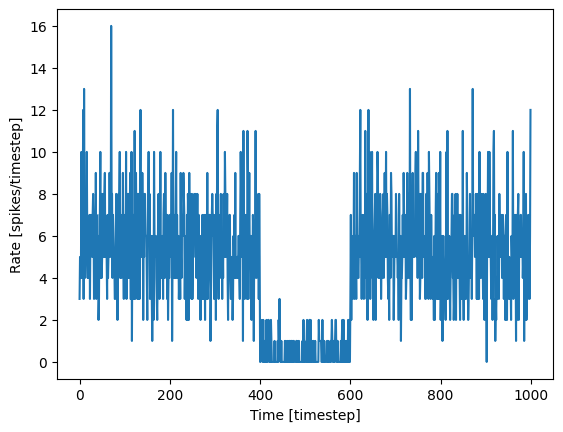

In [4]:
fig, axis = plt.subplots()
axis.plot(data)
axis.set_ylabel("Rate [spikes/timestep]")
axis.set_xlabel("Time [timestep]")

# Layer classes
FeNN is programmed using a small number of primitive objects:
*   ``Processes`` perform computation
*   ``Variables`` are used to hold model state e.g. neuron variables and weights
*   ``EventContainers`` are the primary means of communication between neuron processes

The FeNN tools don't really enforce any particular style of modelling but you can easily use these primitives to create PyTorchesque layer objects. We start by creating a leaky integrator for the output layer. This integrates an input current + bias into a membrane voltage which is averaged over the trial. The update to be performed each timestep is implemented in a ``NeuronUpdateProcess`` which performs the same update to each neuron (as dictated by the same of the variables). In future, these processes might be Just-in-Time compiled from Python but, right now, they are implemented in [GeNNCode](https://genn-team.github.io/genn/documentation/5/custom_models.html#genncode). This is basically a subset of C with extensions for fixed-point types inspired by the [ISO standard extension](https://www.open-std.org/jtc1/sc22/wg14/www/docs/n1005.pdf). Here we define an Adaptive LIF neuron which integrates a tensor of input currents. Fixed-point types are specified as strings, for example s9_6_sat_t is a signed 16-bit fixed point type (this is all FeNN currently supports) with 9 integer and 6 fractional bits to which saturation should be applied (currently only when adding and subtracting):

In [5]:
class ALIF:
    def __init__(self, shape, tau_m: float, tau_a: float, tau_refrac: int,
                 v_thresh: float, beta: float, weight:float, num_timesteps: int):
        self.shape = Shape(shape)
        v_dtype = UnresolvedType("s6_9_sat_t")
        a_dtype = UnresolvedType("s6_9_sat_t")
        decay_dtype = UnresolvedType("s0_15_sat_t")
        self.v = Variable(self.shape, v_dtype)
        self.a = Variable(self.shape, a_dtype)
        self.i = Variable(self.shape, UnresolvedType("int16_t"), num_timesteps)
        self.refrac_time = Variable(self.shape, UnresolvedType("int16_t"))
        self.process = NeuronUpdateProcess(
            """
            V = (Alpha * V) + (Weight * I);
            A *= Rho;

            if (RefracTime > 0) {
               RefracTime -= 1;
            }
            else if(V >= (VThresh + (Beta * A))) {
               V -= VThresh;
               A += 1.0h9;
               RefracTime = TauRefrac;
            }
            """,
            {"Alpha": Parameter(NumericValue(np.exp(-1.0 / tau_m)), decay_dtype),
             "Rho": Parameter(NumericValue(np.exp(-1.0 / tau_a)), decay_dtype),
             "VThresh": Parameter(NumericValue(v_thresh), v_dtype),
             "Beta": Parameter(NumericValue(beta), v_dtype),
             "Weight": Parameter(NumericValue(weight), v_dtype),
             "TauRefrac": Parameter(NumericValue(tau_refrac), UnresolvedType("int16_t"))},
            {"V": self.v, "A": self.a, "I": self.i, "RefracTime": self.refrac_time})


Finally, and this is purely a hack because the DMA controller in FeNN is currently unable to directly copy data back to the host, we define a CopyProcess which does this using the processor:

In [6]:
class Copy:
    def __init__(self, source: Variable, num_timesteps: int = 1):
        self.target = Variable(source.shape,
                               UnresolvedType(source.type),
                               num_timesteps,
                               f"{source.name}_copy")
        self.process = CopyProcess(source, self.target)

# Model definition
The FeNN tools can produce lots of helpful logging information so we initialise this system before we do anything else (if you use ``from pyfenn import PlogSeverity`` to import the enum you can then use e.g. ``PlogSeverity.DEBUG`` to control the logging level):

In [7]:
init_logging()


Then create a neuron layer using the classes we defined above:

In [8]:
neurons = ALIF([32], 20.0, 2000, 5, 0.6, 0.0174, 0.01, num_timesteps)

Then, two of our hacky copy processes to copy the V and A variables back from FeNN:



In [9]:
copy_v = Copy(neurons.v, num_timesteps)
copy_a = Copy(neurons.a, num_timesteps)

Process groups define computation that can be performed in parallel (in fact, on FeNN it's not but this won't be the case with e.g. GPU backends) so we group our neuron update processes and copy processes into seperate groups

In [10]:
neuron_update_processes = ProcessGroup([neurons.process])
copy_processes = ProcessGroup([copy_v.process, copy_a.process])

Now we define a model which groups together all parts of our simulation:

In [11]:
model = Model([neuron_update_processes, copy_processes])

# Simulation
Sadly Google has yet to install FeNN nodes into it's cloud so for now we create a simulation backend (if you are lucky enough to be running on a Kria KV260 with the bitstream loaded, you should substitute ``BackendFeNNHW`` here) and use it to create a generic simulation kernel. The control flow of these kernels *will* be fully programmable but for now you can either create a really simple kernel which just runs a list of process groups or a 'simulation' kernel which offloads running a loop over time with a list of process groups in the body and another list that runs at the end (which we use here to copy output classifications off of FeNN)

In [12]:
backend = BackendFeNNSim()
code = backend.generate_simulation_kernel([neuron_update_processes, copy_processes],
                                          [],
                                          num_timesteps, model)

Now we have some code, we create a ``Runtime`` object to interact with the FeNN. We first use this to allocate the memory required for our model on FeNN:

In [13]:
runtime = Runtime(model, backend)
runtime.allocate()

Now we use some helper functions to zero state variables:

In [14]:
zero_and_push(neurons.v, runtime)
zero_and_push(neurons.a, runtime)
zero_and_push(neurons.refrac_time, runtime)

and some more to copy our input currents (duplicated across all 32 ALIF neurons) to FeNN:

In [15]:
input_i_array, input_i_view = get_array_view(runtime, neurons.i, np.int16)
input_i_view[:] = repeated_data.flatten()
input_i_array.push_to_device()

Then we upload the code generated by the backend to FeNN:

In [16]:
runtime.set_instructions(code)

and finally we run our kernel:

In [17]:
runtime.run()

Having filled up all of FeNN's memory with A and V recordings, we now want to access them! The ``Runtime`` object creates a bunch of 'Array' objects which are used to interact with model state so we first get them from the copy processes and copy their contents to the host:

In [18]:
neurons_v_copy_array, neurons_v_copy_view = get_array_view(runtime, copy_v.target,
                                                           np.int16)
neurons_a_copy_array, neurons_a_copy_view = get_array_view(runtime, copy_a.target,
                                                           np.int16)

neurons_v_copy_array.pull_from_device()
neurons_a_copy_array.pull_from_device()

# **YUCK** reshape
neurons_v_copy_view = np.reshape(neurons_v_copy_view, (-1, 32))
neurons_a_copy_view = np.reshape(neurons_a_copy_view, (-1, 32))

Finally, we can calculate means and standard deviations (only relevant with stochastic rounding) and plot:

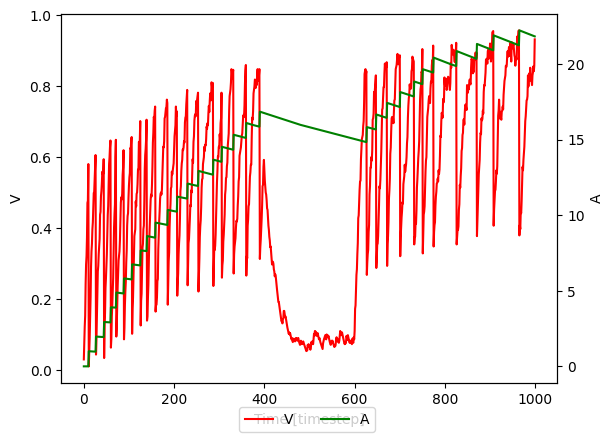

In [19]:
neurons_v_mean = np.average(neurons_v_copy_view, axis=1)
neurons_v_std = np.std(neurons_v_copy_view, axis=1)
neurons_a_mean = np.average(neurons_a_copy_view, axis=1)
neurons_a_std = np.std(neurons_a_copy_view, axis=1)
fig, axis = plt.subplots()

a_axis = axis.twinx()
scale = 1.0 / (2 ** 9)
v_actor = axis.plot(neurons_v_mean * scale, color="red")[0]
a_actor = a_axis.plot(neurons_a_mean * scale, color="green")[0]
fig.legend([v_actor, a_actor], ["V", "A"], loc="lower center", ncols=2)

axis.set_ylabel("V")
a_axis.set_ylabel("A")
axis.set_xlabel("Time [timestep]")

plt.show()

# Disassembling 😥
Sometimes it's cool to know what's happening under the hood so, by using the ``disassemble`` function you can disassemble the code produced be the backend into a slightly friendly form. A slightly outdated description of the instruction set is provided at https://github.com/neworderofjamie/riscv_ise/blob/master/docs/instruction_set.pdf

In [20]:
for i, c in enumerate(code):
    print(f"{i * 4} : {disassemble(c)}")

0 : ADDI X1, X0, 0
4 : ADDI X2, X0, 1000
8 : VLUI V2, 512
12 : VLUI V1, 1
16 : VLUI V0, 0
20 : ADDI X3, X0, 64
24 : LW X4, 0(X0)
28 : LW X5, 4(X0)
32 : MUL X6, X1, X3
36 : ADD X5, X5, X6
40 : LW X6, 8(X0)
44 : LW X7, 12(X0)
48 : VLUI V3, 5
52 : VLUI V4, 5
56 : VLUI V5, 9
60 : VLUI V6, 32752
64 : VLUI V7, 307
68 : VLUI V8, 31170
72 : VLOAD V9, 0(X4)
76 : VLOAD V10, 0(X5)
80 : VLOAD V11, 0(X6)
84 : VLOAD V12, 0(X7)
88 : VMUL V13, V8, V12, 15
92 : VMUL V14, V4, V10, 0
96 : VADD_S V15, V13, V14
100 : VADD V12, V15, V0
104 : VMUL V11, V11, V6, 15
108 : VTLT X3, V0, V9
112 : VSUB V13, V9, V1
116 : VSEL V9, X3, V13
120 : XORI X8, X3, -1
124 : VMUL V13, V5, V11, 9
128 : VADD_S V14, V7, V13
132 : VTGE X9, V12, V14
136 : AND X10, X8, X9
140 : VSUB_S V13, V12, V7
144 : VSEL V12, X10, V13
148 : VADD_S V13, V11, V2
152 : VSEL V11, X10, V13
156 : VSEL V9, X10, V3
160 : VSTORE V9, 0(X4)
164 : VSTORE V10, 0(X5)
168 : VSTORE V11, 0(X6)
172 : VSTORE V12, 0(X7)
176 : LW X4, 16(X0)
180 : LW X3, 20(X0)
184